# Hypervectors with decay

The roll operation or the random orthogonal matrix has an important property defined by the eigenvalues. For roll or random orth matrices the eigenvalues are all 1, which means that the hypervector/rnn will attempt to store all information from all time. We have seen how the chaos will build up until no information can be stored. This means that the most recent input or the first input have the same likelihoods of being correctly read out. 

In the context of RNNs this is potentially harmful. This is because an RNN getting a continuous stream of input will fill up at some point, and chaos will dominate its dynamics instead of information. When this happens, even the most recent items added to the RNN will be undecodable. This means that the RNN has filled up, and it is over capacity.

A more useful RNN could have memory only for a finite amount of history. In this case, we could imagine the weight matrix having eigenvalue slightly less than 1, or we decay the hypervector by a small amount each time step. This type of decay will exponentially decrease the information energy in the hypervector, and should enable storage of recent sequences indefinitely, but perhaps at the cost of not being able to store quite as much.

We saw that the memory 


In [5]:
import random_idx
import utils
import pickle
import time
import string
from pylab import *
%matplotlib inline

In [6]:
def test_capacity_decay(N, D, decay=1, K=5, trials=5e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = decay * np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [7]:
test_N = [2000]
test_D = [2, 4, 8, 16, 32, 64]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

K=20

for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_decay(N, D, decay=0.99, K=K)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            lidx_li_all.append(lidx_li)
            lidx_iK_all.append(lidx_iK)
            lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity_decay-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D)


0
Duration:  0.47229218483
Duration:  0.516049146652
Duration:  0.961056947708
Duration:  1.34201288223
Duration:  2.11495089531
Duration:  4.03235888481
1
Duration:  0.482956886292
Duration:  0.64165687561
Duration:  0.944880962372
Duration:  1.4232480526
Duration:  2.37992215157
Duration:  3.61535096169
2
Duration:  0.465167045593
Duration:  0.493376016617
Duration:  0.847532987595
Duration:  1.37761998177
Duration:  1.99725484848
Duration:  4.2298810482
3
Duration:  0.471251010895
Duration:  0.467211008072
Duration:  0.827053070068
Duration:  1.36111402512
Duration:  2.40849709511
Duration:  4.36162281036
4
Duration:  0.414444208145
Duration:  0.46590590477
Duration:  0.826478004456
Duration:  1.39579200745
Duration:  2.36223196983
Duration:  4.213367939
data/hypervector_capacity_decay-N=1-D=6-r=5-n160419.npz


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

In [8]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uD)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uD)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uD)))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for i in idxs:
        li_mean[:,iD] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iD] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iD] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


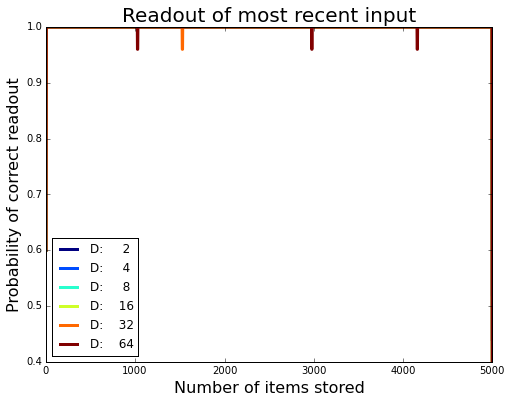

In [9]:
figure(figsize=(8,6))

cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="D: %5i" % test_D[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)


**Figure: Hypervector with decay can store most recent input indefinitely.**


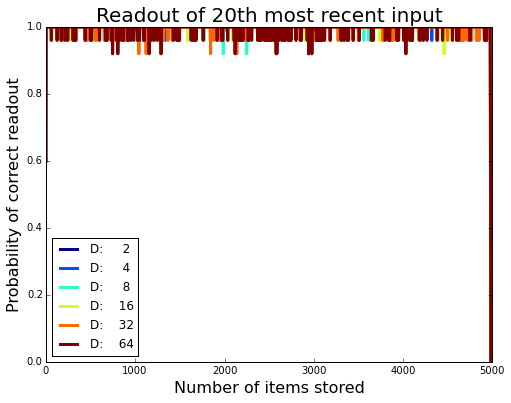

In [10]:
figure(figsize=(8,6))

cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="D: %5i" % test_D[i])
    
legend(loc='lower left');
title('Readout of %dth most recent input' % K, fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)


**Figure: Hypervector with decay can store 20th most recent input indefinitely.**


(0, 1000)

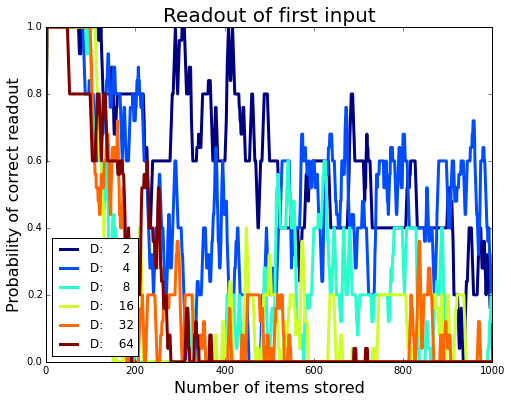

In [11]:
figure(figsize=(8,6))

cm=get_cmap('jet', li_mean.shape[1])

for i in range(fi_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="D: %5i" % test_D[i])
    
legend(loc='lower left');
title('Readout of first input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
xlim([0, 1000])